In addition to standard `numpy`, `matplotlib` and `astropy`, need to also install `sklearn` (for `FastICA`), `GPy` and `gpr4im` (for Gaussian processes) using pip.

In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import GPy
from gpr4im import fg_tools as fg
from gpr4im import pk_tools as pk
from gpr4im import obs_tools as obs

Import testing data, where the simulated 21cm data has been generated using 21cmFast (https://21cmfast.readthedocs.io/en/latest/) and the foregrounds by (https://github.com/chapmanemma/PythonFGSim/blob/main/foreground_sim.py)

In [2]:
#define variables
bins = 20
components = 4
pixel_size = 100
angle = 2.6
box_len = 100
num_of_freqs = 150

In [3]:
#simulated synchrtron foregrounds
syn_fg_hdl =  fits.open('syn_test.fits')
syn_fg = syn_fg_hdl[0].data
syn_fg_hdl.close()

#simulated free-free foregrounds
ff_fg_hdl =  fits.open('ff_test.fits')
ff_fg = ff_fg_hdl[0].data
ff_fg_hdl.close()

lc_hdl =  fits.open('lightcone_100MPc.fits')
lc = lc_hdl[0].data
lc_hdl.close()

total_fg = syn_fg + ff_fg

#lightcone needs to be zero meaned and in K (currently in mK) - just necessary because of how the simulation was made
zm_data = np.empty(lc.shape)
for ii in range(0,num_of_freqs):
    mean = np.mean(lc[:,:,ii])
    zm_data[:,:,ii] = lc[:,:,ii] - mean 
_21cm = zm_data/1000

total_data = _21cm + total_fg

Using FastICA as a foreground removal technique using https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html

To use FastICA the data must be in the form (x,y) where x is all the image pixels in one long continous array of all the pixels and y is an array of all the frequencies for each slice

In [4]:
reshape_data = total_data.reshape((pixel_size*pixel_size,num_of_freqs))

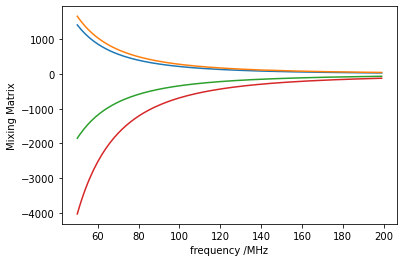

In [5]:
#initilise FastICA class with 4 components
f_ica = FastICA(n_components=4)
#generate the 4 componets
S = f_ica.fit_transform(reshape_data)

#get mixing matrix
A = f_ica.mixing_

#plot mixing matrix
frequency = np.arange(50,200,1)
plt.plot(frequency , A)
plt.xlabel('frequency /MHz')
plt.ylabel('Mixing Matrix')
plt.show()




If FastICA has manage to model all of the variation in the data then it should be able to recreate the data from the matrix multiplication of the mixing matrix and the FastICA components. For example if A is the Mixing matrix and S is the array of components then: image = AS

For foreground removal we assume AS models the foregrounds so then residuals should be the 21cm signal and any noise/telescope effects: image = AS + noise + 21cm 

In [6]:
#create reconstructed fg

model_fICA = (np.matmul(A,S.T).T).reshape((pixel_size,pixel_size,num_of_freqs))

#create residuals
resids_fICA = total_data - model_fICA #residuals 

The residuals (plotted below and on the right) should be the same as the 21cm signal plus any noise present (if the foreground removal has worked correctly. The colourbars show temperature in K

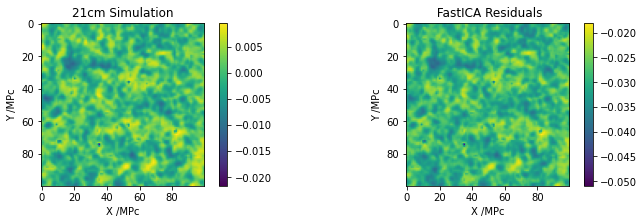

In [7]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,2,1)
im = ax.imshow(_21cm[:,:,50])
ax.set_xlabel('X /MPc')
ax.set_ylabel('Y /MPc')
ax.set_title('21cm Simulation')
fig.colorbar(im, ax=ax)
clim = im.properties()['clim']
ax = fig.add_subplot(1,2,2)
im = ax.imshow(resids_fICA[:,:,50])
ax.set_xlabel('X /MPc')
ax.set_ylabel('Y /MPc')
ax.set_title(' FastICA Residuals')
fig.colorbar(im, ax=ax)




The model (shown below and on the right) should be the same as the foregrounds

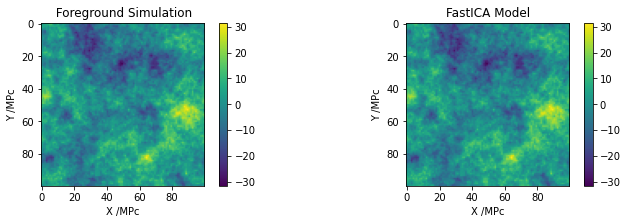

In [8]:
fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,2,1)
im = ax.imshow(total_fg[:,:,50])
ax.set_xlabel('X /MPc')
ax.set_ylabel('Y /MPc')
ax.set_title(' Foreground Simulation')
fig.colorbar(im, ax=ax)
clim = im.properties()['clim']
ax = fig.add_subplot(1,2,2)
im = ax.imshow(model_fICA[:,:,50],clim=clim)
ax.set_xlabel('X /MPc')
ax.set_ylabel('Y /MPc')
ax.set_title('FastICA Model')
fig.colorbar(im, ax=ax)
plt.show()

Foreground removal using Gaussian Process Regression techniques (https://github.com/paulassoares/gpr4im)

For GPR I had to use kernels to model the different effects, I have used the ones outlined in Hothi et al 2020 (https://arxiv.org/abs/2011.01284) and Mertens et al 2020 https://ui.adsabs.harvard.edu/abs/2020MNRAS.493.1662M/abstract)

For the 21cm signal they used a exponetial kernel, for the foregrounds they used a gaussian kernel (to model the smooth foregrounds) plus a matern 3/2 kenrel plus a matern 5/2 kernel, for the noise from the telescope they used a white kernel,

I haven't added anay telescope effects to this simulated data so I haven't included the white kernel here but I presume we would need to for the data challenge

GPRclean input has to be in the shape (images, frequency) with the images as a 2D array, it doesn't work if the file is in the shape (frequency, images)

In [9]:
#choose kernel
# kernel for the smooth foreground:
kern_sfg = GPy.kern.RBF(1)
#mixing kernel
kern_mix = GPy.kern.Matern32(1)
#ex kernel
kern_ex = GPy.kern.Matern52(1)
# kernel for the HI cosmological signal:
kern_21 = GPy.kern.Exponential(1)
#set lengthscales to ensure the kernals fit to the correcrt part of the signal based on the data in Mertens et al 2020

kern_sfg.lengthscale.constrain_bounded(10,100)
kern_21.lengthscale.constrain_bounded(0.1,1.2)
kern_mix.lengthscale.constrain_bounded(1,10)
kern_ex.lengthscale.constrain_bounded(0.2,8)
kern_fg = kern_sfg + kern_mix + kern_ex

gpr_result = fg.GPRclean(total_data, frequency, kern_fg, kern_21, NprePCA=0, num_restarts=10,
                                          noise_data=None, heteroscedastic=False, zero_noise=True, invert=False)



reconstraining parameters rbf.lengthscale
reconstraining parameters Exponential.lengthscale
reconstraining parameters Mat32.lengthscale
reconstraining parameters Mat52.lengthscale
 /home/ppxjf3/anaconda3/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


Optimization restart 1/10, f = -3441234.9112520255
Optimization restart 2/10, f = -4765311.5884412415
Optimization restart 3/10, f = -3441235.1439127414
Optimization restart 4/10, f = -3038935.7786150193
Optimization restart 5/10, f = -3528441.3783155694
Optimization restart 6/10, f = -3441235.3408199847
Optimization restart 7/10, f = -4722548.400485748
[[1734077.09177571 1733990.39008866 1733730.31103655 ...  588619.8829362
   580001.45680888  571452.0714718 ]
 [1733990.39008866 1734077.09177571 1733990.39008866 ...  597306.63934804
   588619.8829362   580001.45680888]
 [1733730.31103655 1733990.39008866 1734077.09177571 ...  606060.98436806
   597306.63934804  588619.8829362 ]
 ...
 [ 588619.8829362   597306.63934804  606060.98436806 ... 1734077.09177571
  1733990.39008866 1733730.31103655]
 [ 580001.45680888  588619.8829362   597306.63934804 ... 1733990.39008866
  1734077.09177571 1733990.39008866]
 [ 571452.0714718   580001.45680888  588619.8829362  ... 1733730.31103655
  1733990.3

 /home/ppxjf3/anaconda3/lib/python3.9/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


If f is big and negative then GPR is doing well

In [10]:
model_gpr = gpr_result.fgfit 
resids_gpr = total_data - model_gpr

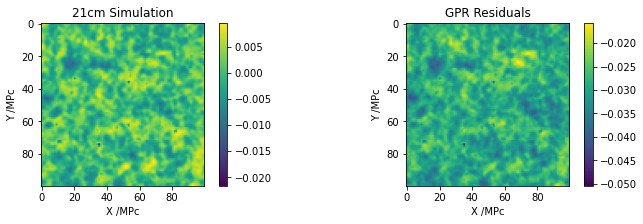

In [11]:
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(1,2,1)
im = ax.imshow(_21cm[:,:,50])
ax.set_xlabel('X /MPc')
ax.set_ylabel('Y /MPc')
ax.set_title('21cm Simulation')
fig.colorbar(im, ax=ax)
clim = im.properties()['clim']
ax = fig.add_subplot(1,2,2)
im = ax.imshow(resids_gpr[:,:,50])
ax.set_xlabel('X /MPc')
ax.set_ylabel('Y /MPc')
ax.set_title('GPR Residuals')
fig.colorbar(im, ax=ax)



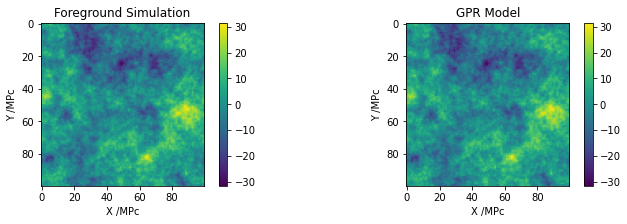

In [12]:

fig = plt.figure(figsize=(12,3))
ax=fig.add_subplot(1,2,1)
im = ax.imshow(total_fg[:,:,50])
ax.set_xlabel('X /MPc')
ax.set_ylabel('Y /MPc')
ax.set_title('Foreground Simulation')
fig.colorbar(im, ax=ax)
clim = im.properties()['clim']
ax = fig.add_subplot(1,2,2)
im = ax.imshow(model_gpr[:,:,50],clim=clim)
ax.set_xlabel('X /MPc')
ax.set_ylabel('Y /MPc')
ax.set_title('GPR Model')
fig.colorbar(im, ax=ax)
plt.show()